In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [3]:
import pytorch_optimizer as optim

In [4]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
import torchvision.datasets
from tqdm import tqdm
import pandas as pd

In [6]:
CIFAR_train = torchvision.datasets.CIFAR100('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR100('./', download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [10]:
X_train /= 255.
X_test /= 255.

In [11]:
CIFAR_train.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

tensor(19) tensor(29) tensor(0) tensor(11) tensor(1) tensor(86) tensor(90) tensor(28) tensor(23) tensor(31) 

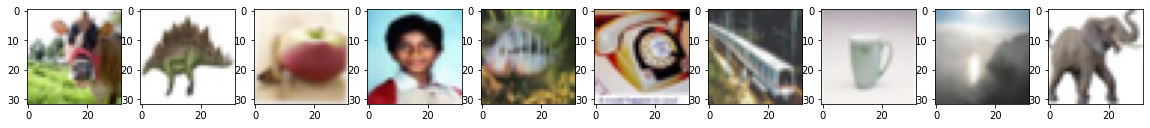

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [13]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [29]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(net.parameters(), lr=1.0e-3)
    #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
    #optimizer = optim.PNMBelief(net.parameters(), lr=0.001)
    #optimizer = optim.YogiPNM(net.parameters(), lr=0.001)
    #optimizer = optim.AdaBelief(net.parameters())
    optimizer = optim.DiffGrad(net.parameters())
    #optimizer = optim.Yogi(net.parameters())
    
    batch_size = 200

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        #if epoch == 8:
            #print("lr=1.0e-4")
            #optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)


        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")
    del net
    return test_accuracy_history, test_loss_history



In [17]:
accuracies = {}
losses = {}

In [18]:
from torchvision.models import densenet121, DenseNet121_Weights
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [19]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+Adam'], losses['densenet121+Adam'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:43<00:00,  5.73it/s]


accuracy =  0.2603999972343445



epoch  1


100%|██████████| 250/250 [00:33<00:00,  7.38it/s]


accuracy =  0.432699978351593



epoch  2


100%|██████████| 250/250 [00:32<00:00,  7.70it/s]


accuracy =  0.4917999804019928



epoch  3


100%|██████████| 250/250 [00:31<00:00,  7.97it/s]


accuracy =  0.5238999724388123



epoch  4


100%|██████████| 250/250 [00:32<00:00,  7.59it/s]


accuracy =  0.5291000008583069



epoch  5


100%|██████████| 250/250 [00:31<00:00,  7.94it/s]


accuracy =  0.5289999842643738



epoch  6


100%|██████████| 250/250 [00:32<00:00,  7.69it/s]


accuracy =  0.5430999994277954



epoch  7


100%|██████████| 250/250 [00:31<00:00,  7.93it/s]


accuracy =  0.5414000153541565



epoch  8


100%|██████████| 250/250 [00:32<00:00,  7.67it/s]


accuracy =  0.542199969291687



epoch  9


100%|██████████| 250/250 [00:32<00:00,  7.66it/s]


accuracy =  0.5460999608039856



epoch  10


100%|██████████| 250/250 [00:32<00:00,  7.68it/s]


accuracy =  0.5435000061988831



epoch  11


100%|██████████| 250/250 [00:32<00:00,  7.63it/s]


accuracy =  0.5467999577522278



epoch  12


100%|██████████| 250/250 [00:31<00:00,  8.05it/s]


accuracy =  0.5442999601364136



epoch  13


100%|██████████| 250/250 [00:31<00:00,  7.86it/s]


accuracy =  0.5467999577522278



epoch  14


100%|██████████| 250/250 [00:31<00:00,  8.01it/s]


accuracy =  0.5414000153541565



epoch  15


100%|██████████| 250/250 [00:31<00:00,  7.97it/s]


accuracy =  0.5496999621391296



epoch  16


100%|██████████| 250/250 [00:31<00:00,  7.83it/s]


accuracy =  0.5494999885559082



epoch  17


100%|██████████| 250/250 [00:31<00:00,  7.88it/s]


accuracy =  0.5453999638557434



epoch  18


100%|██████████| 250/250 [00:31<00:00,  7.86it/s]


accuracy =  0.5494999885559082



epoch  19


100%|██████████| 250/250 [00:32<00:00,  7.77it/s]


accuracy =  0.5511000156402588





In [21]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+SGD'], losses['densenet121+SGD'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:25<00:00,  9.81it/s]


accuracy =  0.03099999949336052



epoch  1


100%|██████████| 250/250 [00:25<00:00,  9.79it/s]


accuracy =  0.06350000202655792



epoch  2


100%|██████████| 250/250 [00:24<00:00, 10.02it/s]


accuracy =  0.12999999523162842



epoch  3


100%|██████████| 250/250 [00:25<00:00,  9.94it/s]


accuracy =  0.1891999989748001



epoch  4


100%|██████████| 250/250 [00:24<00:00, 10.17it/s]


accuracy =  0.23269999027252197



epoch  5


100%|██████████| 250/250 [00:25<00:00,  9.98it/s]


accuracy =  0.2638999819755554



epoch  6


100%|██████████| 250/250 [00:24<00:00, 10.11it/s]


accuracy =  0.2902999818325043



epoch  7


100%|██████████| 250/250 [00:24<00:00, 10.11it/s]


accuracy =  0.311599999666214



epoch  8


100%|██████████| 250/250 [00:25<00:00,  9.93it/s]


accuracy =  0.33319997787475586



epoch  9


100%|██████████| 250/250 [00:25<00:00,  9.81it/s]


accuracy =  0.3568999767303467



epoch  10


100%|██████████| 250/250 [00:25<00:00,  9.83it/s]


accuracy =  0.3685999810695648



epoch  11


100%|██████████| 250/250 [00:25<00:00,  9.84it/s]


accuracy =  0.3837999999523163



epoch  12


100%|██████████| 250/250 [00:25<00:00,  9.82it/s]


accuracy =  0.39489999413490295



epoch  13


100%|██████████| 250/250 [00:25<00:00,  9.86it/s]


accuracy =  0.4050000011920929



epoch  14


100%|██████████| 250/250 [00:25<00:00,  9.84it/s]


accuracy =  0.41609999537467957



epoch  15


100%|██████████| 250/250 [00:24<00:00, 10.15it/s]


accuracy =  0.42719998955726624



epoch  16


100%|██████████| 250/250 [00:24<00:00, 10.10it/s]


accuracy =  0.4332999885082245



epoch  17


100%|██████████| 250/250 [00:25<00:00, 10.00it/s]


accuracy =  0.4381999969482422



epoch  18


100%|██████████| 250/250 [00:25<00:00,  9.99it/s]


accuracy =  0.4404999911785126



epoch  19


100%|██████████| 250/250 [00:25<00:00,  9.94it/s]


accuracy =  0.44919997453689575





In [24]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+PNMBelief'], losses['densenet121+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:38<00:00,  6.54it/s]


accuracy =  0.4348999857902527



epoch  1


100%|██████████| 250/250 [00:38<00:00,  6.55it/s]


accuracy =  0.4869999885559082



epoch  2


100%|██████████| 250/250 [00:38<00:00,  6.55it/s]


accuracy =  0.5235999822616577



epoch  3


100%|██████████| 250/250 [00:38<00:00,  6.54it/s]


accuracy =  0.5667999982833862



epoch  4


100%|██████████| 250/250 [00:38<00:00,  6.56it/s]


accuracy =  0.5812999606132507



epoch  5


100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


accuracy =  0.5688999891281128



epoch  6


100%|██████████| 250/250 [00:37<00:00,  6.58it/s]


accuracy =  0.5733000040054321



epoch  7


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


accuracy =  0.5773999691009521



epoch  8


100%|██████████| 250/250 [00:38<00:00,  6.56it/s]


accuracy =  0.5794999599456787



epoch  9


100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


accuracy =  0.5824999809265137



epoch  10


100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


accuracy =  0.5839999914169312



epoch  11


100%|██████████| 250/250 [00:38<00:00,  6.55it/s]


accuracy =  0.5931999683380127



epoch  12


100%|██████████| 250/250 [00:38<00:00,  6.51it/s]


accuracy =  0.5932999849319458



epoch  13


100%|██████████| 250/250 [00:38<00:00,  6.46it/s]


accuracy =  0.5841000080108643



epoch  14


100%|██████████| 250/250 [00:37<00:00,  6.62it/s]


accuracy =  0.599399983882904



epoch  15


100%|██████████| 250/250 [00:37<00:00,  6.61it/s]


accuracy =  0.6037999987602234



epoch  16


100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


accuracy =  0.6098999977111816



epoch  17


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


accuracy =  0.6103999614715576



epoch  18


100%|██████████| 250/250 [00:37<00:00,  6.68it/s]


accuracy =  0.6150999665260315



epoch  19


100%|██████████| 250/250 [00:37<00:00,  6.71it/s]


accuracy =  0.6200999617576599





In [26]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+YogiPNM'], losses['densenet121+YogiPNM'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:38<00:00,  6.42it/s]


accuracy =  0.4493999779224396



epoch  1


100%|██████████| 250/250 [00:38<00:00,  6.57it/s]


accuracy =  0.5577999949455261



epoch  2


100%|██████████| 250/250 [00:39<00:00,  6.39it/s]


accuracy =  0.5640999674797058



epoch  3


100%|██████████| 250/250 [00:39<00:00,  6.27it/s]


accuracy =  0.5914999842643738



epoch  4


100%|██████████| 250/250 [00:39<00:00,  6.34it/s]


accuracy =  0.6013999581336975



epoch  5


100%|██████████| 250/250 [00:37<00:00,  6.66it/s]


accuracy =  0.592199981212616



epoch  6


100%|██████████| 250/250 [00:37<00:00,  6.59it/s]


accuracy =  0.5970999598503113



epoch  7


100%|██████████| 250/250 [00:37<00:00,  6.62it/s]


accuracy =  0.6001999974250793



epoch  8


100%|██████████| 250/250 [00:37<00:00,  6.62it/s]


accuracy =  0.5999999642372131



epoch  9


100%|██████████| 250/250 [00:37<00:00,  6.65it/s]


accuracy =  0.6115999817848206



epoch  10


100%|██████████| 250/250 [00:37<00:00,  6.62it/s]


accuracy =  0.602899968624115



epoch  11


100%|██████████| 250/250 [00:37<00:00,  6.65it/s]


accuracy =  0.5976999998092651



epoch  12


100%|██████████| 250/250 [00:37<00:00,  6.58it/s]


accuracy =  0.6098999977111816



epoch  13


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


accuracy =  0.6075999736785889



epoch  14


100%|██████████| 250/250 [00:37<00:00,  6.75it/s]


accuracy =  0.6132000088691711



epoch  15


100%|██████████| 250/250 [00:37<00:00,  6.73it/s]


accuracy =  0.6137999892234802



epoch  16


100%|██████████| 250/250 [00:37<00:00,  6.69it/s]


accuracy =  0.6193000078201294



epoch  17


100%|██████████| 250/250 [00:37<00:00,  6.64it/s]


accuracy =  0.6222000122070312



epoch  18


100%|██████████| 250/250 [00:37<00:00,  6.62it/s]


accuracy =  0.6146999597549438



epoch  19


100%|██████████| 250/250 [00:37<00:00,  6.64it/s]


accuracy =  0.6245999932289124





In [28]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+AdaBelief'], losses['densenet121+AdaBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:35<00:00,  7.04it/s]


accuracy =  0.39800000190734863



epoch  1


100%|██████████| 250/250 [00:35<00:00,  7.08it/s]


accuracy =  0.5345999598503113



epoch  2


100%|██████████| 250/250 [00:34<00:00,  7.26it/s]


accuracy =  0.5044000148773193



epoch  3


100%|██████████| 250/250 [00:35<00:00,  7.12it/s]


accuracy =  0.5324000120162964



epoch  4


100%|██████████| 250/250 [00:35<00:00,  7.10it/s]


accuracy =  0.5759999752044678



epoch  5


100%|██████████| 250/250 [00:35<00:00,  7.06it/s]


accuracy =  0.5730000138282776



epoch  6


100%|██████████| 250/250 [00:34<00:00,  7.24it/s]


accuracy =  0.5744999647140503



epoch  7


100%|██████████| 250/250 [00:35<00:00,  7.12it/s]


accuracy =  0.5360999703407288



epoch  8


100%|██████████| 250/250 [00:35<00:00,  7.09it/s]


accuracy =  0.5447999835014343



epoch  9


100%|██████████| 250/250 [00:35<00:00,  7.09it/s]


accuracy =  0.5705999732017517



epoch  10


100%|██████████| 250/250 [00:34<00:00,  7.30it/s]


accuracy =  0.5623999834060669



epoch  11


100%|██████████| 250/250 [00:35<00:00,  7.13it/s]


accuracy =  0.5875999927520752



epoch  12


100%|██████████| 250/250 [00:35<00:00,  7.06it/s]


accuracy =  0.5727999806404114



epoch  13


100%|██████████| 250/250 [00:35<00:00,  7.08it/s]


accuracy =  0.5583999752998352



epoch  14


100%|██████████| 250/250 [00:34<00:00,  7.26it/s]


accuracy =  0.557200014591217



epoch  15


100%|██████████| 250/250 [00:35<00:00,  7.10it/s]


accuracy =  0.5771999955177307



epoch  16


100%|██████████| 250/250 [00:35<00:00,  7.07it/s]


accuracy =  0.5643999576568604



epoch  17


100%|██████████| 250/250 [00:35<00:00,  7.10it/s]


accuracy =  0.580299973487854



epoch  18


100%|██████████| 250/250 [00:34<00:00,  7.26it/s]


accuracy =  0.5573999881744385



epoch  19


100%|██████████| 250/250 [00:35<00:00,  7.14it/s]


accuracy =  0.5845000147819519





In [30]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+DiffGrad'], losses['densenet121+DiffGrad'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


accuracy =  0.45159998536109924



epoch  1


100%|██████████| 250/250 [00:45<00:00,  5.45it/s]


accuracy =  0.5432000160217285



epoch  2


100%|██████████| 250/250 [00:40<00:00,  6.25it/s]


accuracy =  0.5701999664306641



epoch  3


100%|██████████| 250/250 [00:39<00:00,  6.25it/s]


accuracy =  0.5849999785423279



epoch  4


100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


accuracy =  0.5774999856948853



epoch  5


100%|██████████| 250/250 [00:40<00:00,  6.25it/s]


accuracy =  0.585599958896637



epoch  6


100%|██████████| 250/250 [00:39<00:00,  6.25it/s]


accuracy =  0.5871999859809875



epoch  7


100%|██████████| 250/250 [00:40<00:00,  6.20it/s]


accuracy =  0.5837000012397766



epoch  8


100%|██████████| 250/250 [00:40<00:00,  6.22it/s]


accuracy =  0.573199987411499



epoch  9


100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


accuracy =  0.5879999995231628



epoch  10


100%|██████████| 250/250 [00:39<00:00,  6.25it/s]


accuracy =  0.5898999571800232



epoch  11


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


accuracy =  0.5862999558448792



epoch  12


100%|██████████| 250/250 [00:39<00:00,  6.27it/s]


accuracy =  0.5892999768257141



epoch  13


100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


accuracy =  0.6060000061988831



epoch  14


100%|██████████| 250/250 [00:40<00:00,  6.20it/s]


accuracy =  0.5929999947547913



epoch  15


100%|██████████| 250/250 [00:43<00:00,  5.72it/s]


accuracy =  0.5909000039100647



epoch  16


100%|██████████| 250/250 [00:44<00:00,  5.62it/s]


accuracy =  0.599399983882904



epoch  17


100%|██████████| 250/250 [00:44<00:00,  5.60it/s]


accuracy =  0.5924000144004822



epoch  18


100%|██████████| 250/250 [00:43<00:00,  5.80it/s]


accuracy =  0.5885999798774719



epoch  19


100%|██████████| 250/250 [00:42<00:00,  5.82it/s]


accuracy =  0.5881999731063843





In [ ]:
model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
accuracies['densenet121+Yogi'], losses['densenet121+Yogi'] = \
    train(model, X_train, y_train, X_test, y_test)

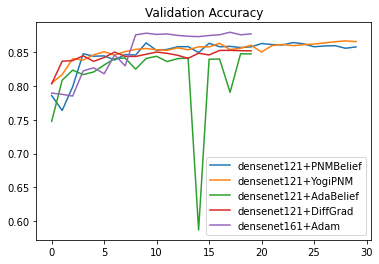

In [ ]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Accuracy');

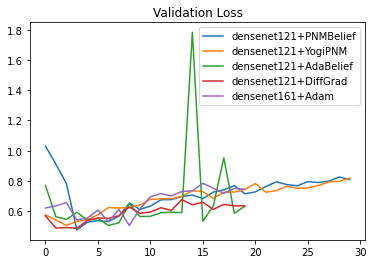

In [ ]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
plt.legend()
plt.title('Validation Loss');

In [ ]:
data = np.zeros((10,10), dtype=int)
D = pd.DataFrame(data)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
test_preds = model.forward(X_test)

In [ ]:
for x, y in zip(test_preds.argmax(dim=1).tolist(), y_test.tolist()):
    D[y][x] += 1

In [ ]:
D